In [1]:
import numpy as np
import pandas as pd
import helper

random_state=25

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ST\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data=pd.read_csv('datasets/data_v3.csv')

In [3]:
data

,mail,label
0,greetings ! y receiv letter express interest r...,spam
1,tr save 70 life insurance spend to ? life quot...,spam
2,need safeti real 2002 might get one chanc rea...,spam
3,1 fight risk cancer ! slim guarante lose 1012...,spam
4,1 fight risk cancer ! slim guarante lose 1012...,spam
...,...,...
5950,from tmdanethistoryhtmlth first releas tmda ap...,ham
5951,justin mason wrote phil r lawrenc said someth...,ham
5952,wed 11 sep 2002 vinc puzzella wrote ever sinc ...,ham
5953,craig hugh said header reproduc full address...,ham


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


X = data.copy()['mail']
y = data.copy()['label'].map({'spam':1,'ham':0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)

In [5]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=30000, token_pattern=r"(?u)\b\w+\b|[!?]")

In [6]:
preprocessor = Pipeline([
    ('flatten', FunctionTransformer(lambda x: x.values.ravel(), validate=False)),
    ('vec', vectorizer)
])

X_train_bow = preprocessor.fit_transform(X_train).toarray()
X_test_bow = preprocessor.transform(X_test).toarray()
headers = list(preprocessor.named_steps['vec'].get_feature_names_out())

In [7]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

kf_train = KFold(n_splits=5, shuffle=True, random_state=random_state)

In [ ]:
logreg = LogisticRegression(random_state=random_state, n_jobs=-1)
sgdc = SGDClassifier(random_state=random_state, n_jobs=-1)
svc = LinearSVC(random_state=random_state)
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(random_state=random_state)
rfc = RandomForestClassifier(random_state=random_state, n_jobs=-1)
abc = AdaBoostClassifier(random_state=random_state)
xgbc = XGBClassifier(random_state=random_state, n_jobs=-1)

models = {
    'Logistic Regression': logreg,
    'SGDClassifier': sgdc,
    'LinearSVC': svc,
    'MultinomialNB': mnb,
    'DecisionTreeClassifier': dtc,
    'RandomForestClassifier': rfc,
    'AdaBoostClassifier': abc,
    'XGBClassifier': xgbc
}

In [9]:
y_proba = {}
for model, obj in models.items():
    scores = np.mean(cross_val_score(obj, X_train_bow, y_train, cv=kf_train, scoring='precision', n_jobs=-1))
    obj.fit(X_train_bow, y_train)
    try:
      y_proba[model] = obj.predict_proba(X_test_bow)
    except:
      pass
    print(f"{model} CV Precision: {scores}")
    print(precision_score(y_test, obj.predict(X_test_bow)))

MultinomialNB CV Precision: 0.9987878787878788
1.0


### There is no need to tune the hyperparameter. We already have pretty amazing models.

## Evaluating Models

In [10]:
from sklearn.metrics import RocCurveDisplay, precision_recall_curve

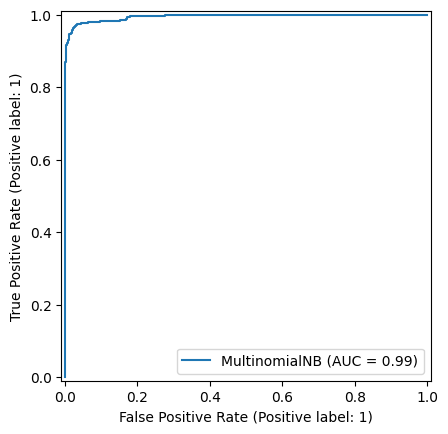

In [11]:
for clf in models.values():
    RocCurveDisplay.from_estimator(clf, X_test_bow, y_test)
    plt.show()

In [12]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba['MultinomialNB'][:,1])

In [13]:
precision.shape

(1433,)

In [14]:
test = pd.DataFrame({
    'threshold': thresholds,
    'precision': precision[1:],
    'recall': recall[1:]
})

In [15]:
prec_max = test['precision'].max()

In [16]:
prec_max

np.float64(1.0)

In [17]:
test

,threshold,precision,recall
0,0.000012,0.278413,1.000000
1,0.000018,0.278788,1.000000
2,0.000018,0.278976,1.000000
3,0.000018,0.279164,1.000000
4,0.000022,0.279541,1.000000
...,...,...,...
1427,0.996470,1.000000,0.012077
1428,0.997123,1.000000,0.009662
1429,0.997137,1.000000,0.004831
1430,0.997205,1.000000,0.002415


In [18]:
test[(test['precision'] >= prec_max - 0.01) & (test['precision'] <= prec_max)].sort_values(by='recall', ascending=False).head(1)['threshold'].values[0]

np.float64(0.2758408439955403)

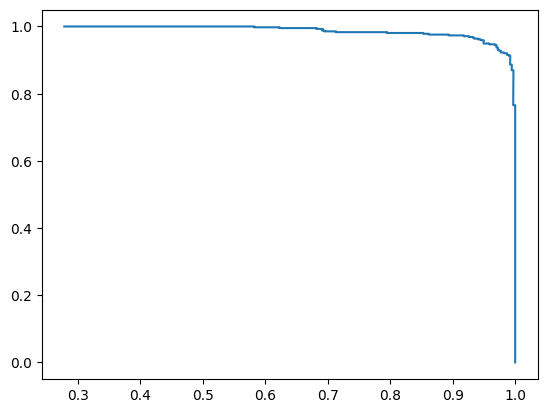

In [19]:
plt.plot(precision,recall)

In [20]:
comp_df = {}
for model, proba in y_proba.items():
  precision, recall, thresholds = precision_recall_curve(y_test, proba[:,1])

  df = pd.DataFrame({
    'threshold': thresholds,
    'precision': precision[1:],
    'recall': recall[1:]
    })
  prec_max = df['precision'].max()
  best_threshold = df[(
      (df['precision'] >= prec_max - 0.01) & (df['precision'] <= prec_max)
      )].sort_values(
          by='recall', ascending=False
          ).head(1)['threshold'].values[0]
  pr = np.round(precision_score(y_test, (proba[:,1] >= best_threshold).astype(int)),2)
  rc = np.round(recall_score(y_test, (proba[:,1] >= best_threshold).astype(int)),2)

  print(f"Best Threshold for {model}: {best_threshold}")
  print(f"Precision at this threshold: {pr}")
  print(f"Recall at this threshold: {rc}")
  comp_df[model] = [best_threshold, pr, rc]

Best Threshold for MultinomialNB: 0.2758408439955403
Precision at this threshold: 0.99
Recall at this threshold: 0.91


In [21]:
comparison_df = pd.DataFrame(comp_df).T.rename({
    0: 'Threshold',
    1: 'Precision',
    2: 'Recall'
}, axis=1)

In [22]:
comparison_df.sort_values(by=['Precision','Recall'], ascending=[False,False])

,Threshold,Precision,Recall
MultinomialNB,0.275841,0.99,0.91


#### Clearly, MNB is performing the best here.
#### It even got a precision of 1.0, but in that case, the max recall we could get was 76%, so I decided to lose 1 percentage point in precision for an increase of about 15 percentage points in recall.

In [23]:
from sklearn.pipeline import Pipeline
import pickle

text_ppl = Pipeline([
    ('clean', helper.CleanBody()),
    ('flatten', FunctionTransformer(helper.flatten_values, validate=False)),
    ('vec', vectorizer),
    ('predict', mnb)
])
text_ppl.fit(X_train, y_train)

with open('text_ppl.pkl', 'wb') as f:
    pickle.dump(text_ppl, f)